# **1. Perkenalan Dataset**


**Sumber Dataset**: [Diabetes Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset)

# **2. Import Library**

In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropCorrelatedFeatures
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# **3. Memuat Dataset**

In [13]:
df = pd.read_csv("../diabetes_health_indicators_raw.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# **4. Exploratory Data Analysis (EDA)**

In [14]:
# Create a DataFrame copy for plotting
df_plot = df.copy()

# Diabetes Target Variable
diabetes_map = {0: "No Diabetes", 1: "Pre-diabetes", 2: "Diabetes"}
df_plot["Diabetes_012"] = df_plot["Diabetes_012"].map(diabetes_map)

# Binary features
binary_map = {0: "No", 1: "Yes"}
binary_features_to_map = [
    "HighBP",
    "HighChol",
    "PhysActivity",
    "Smoker",
    "HeartDiseaseorAttack",
    "Stroke",
    "CholCheck",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
]
for col in binary_features_to_map:
    df_plot[col] = df_plot[col].map(binary_map)

# Sex
sex_map = {0: "Female", 1: "Male"}
df_plot["Sex"] = df_plot["Sex"].map(sex_map)

# General Health
genhlth_map = {1: "Excellent", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}
df_plot["GenHlth"] = df_plot["GenHlth"].map(genhlth_map)

# Age
age_map = {
    1: "18-24",
    2: "25-29",
    3: "30-34",
    4: "35-39",
    5: "40-44",
    6: "45-49",
    7: "50-54",
    8: "55-59",
    9: "60-64",
    10: "65-69",
    11: "70-74",
    12: "75-79",
    13: "80+",
}
df_plot["Age"] = df_plot["Age"].map(age_map)

# Education
education_map = {
    1: "Never Attended",
    2: "Elem. (Grades 1-8)",
    3: "Some High School",
    4: "High School Grad",
    5: "Some College",
    6: "College Grad",
}
df_plot["Education"] = df_plot["Education"].map(education_map)

# Income
income_map = {
    1: "<$10k",
    2: "$10k-$15k",
    3: "$15k-$20k",
    4: "$20k-$25k",
    5: "$25k-$35k",
    6: "$35k-$50k",
    7: "$50k-$75k",
    8: ">$75k",
}
df_plot["Income"] = df_plot["Income"].map(income_map)

# Ensure correct order for ordinal categorical features
df_plot["Diabetes_012"] = pd.Categorical(
    df_plot["Diabetes_012"], categories=list(diabetes_map.values()), ordered=True
)
df_plot["GenHlth"] = pd.Categorical(
    df_plot["GenHlth"], categories=list(genhlth_map.values()), ordered=True
)
df_plot["Age"] = pd.Categorical(
    df_plot["Age"], categories=list(age_map.values()), ordered=True
)
df_plot["Education"] = pd.Categorical(
    df_plot["Education"], categories=list(education_map.values()), ordered=True
)
df_plot["Income"] = pd.Categorical(
    df_plot["Income"], categories=list(income_map.values()), ordered=True
)


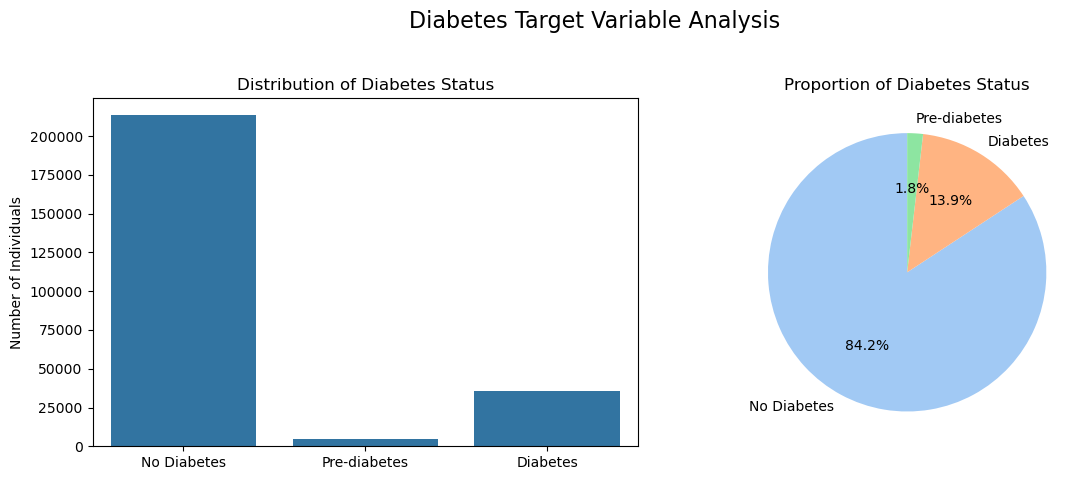

In [15]:
# Target Variable Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Diabetes Target Variable Analysis", fontsize=16)

sns.countplot(data=df_plot, x="Diabetes_012", ax=axes[0])
axes[0].set_title("Distribution of Diabetes Status")
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of Individuals")

df_plot["Diabetes_012"].value_counts().plot.pie(
    ax=axes[1], autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel")
)
axes[1].set_ylabel("")
axes[1].set_title("Proportion of Diabetes Status")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


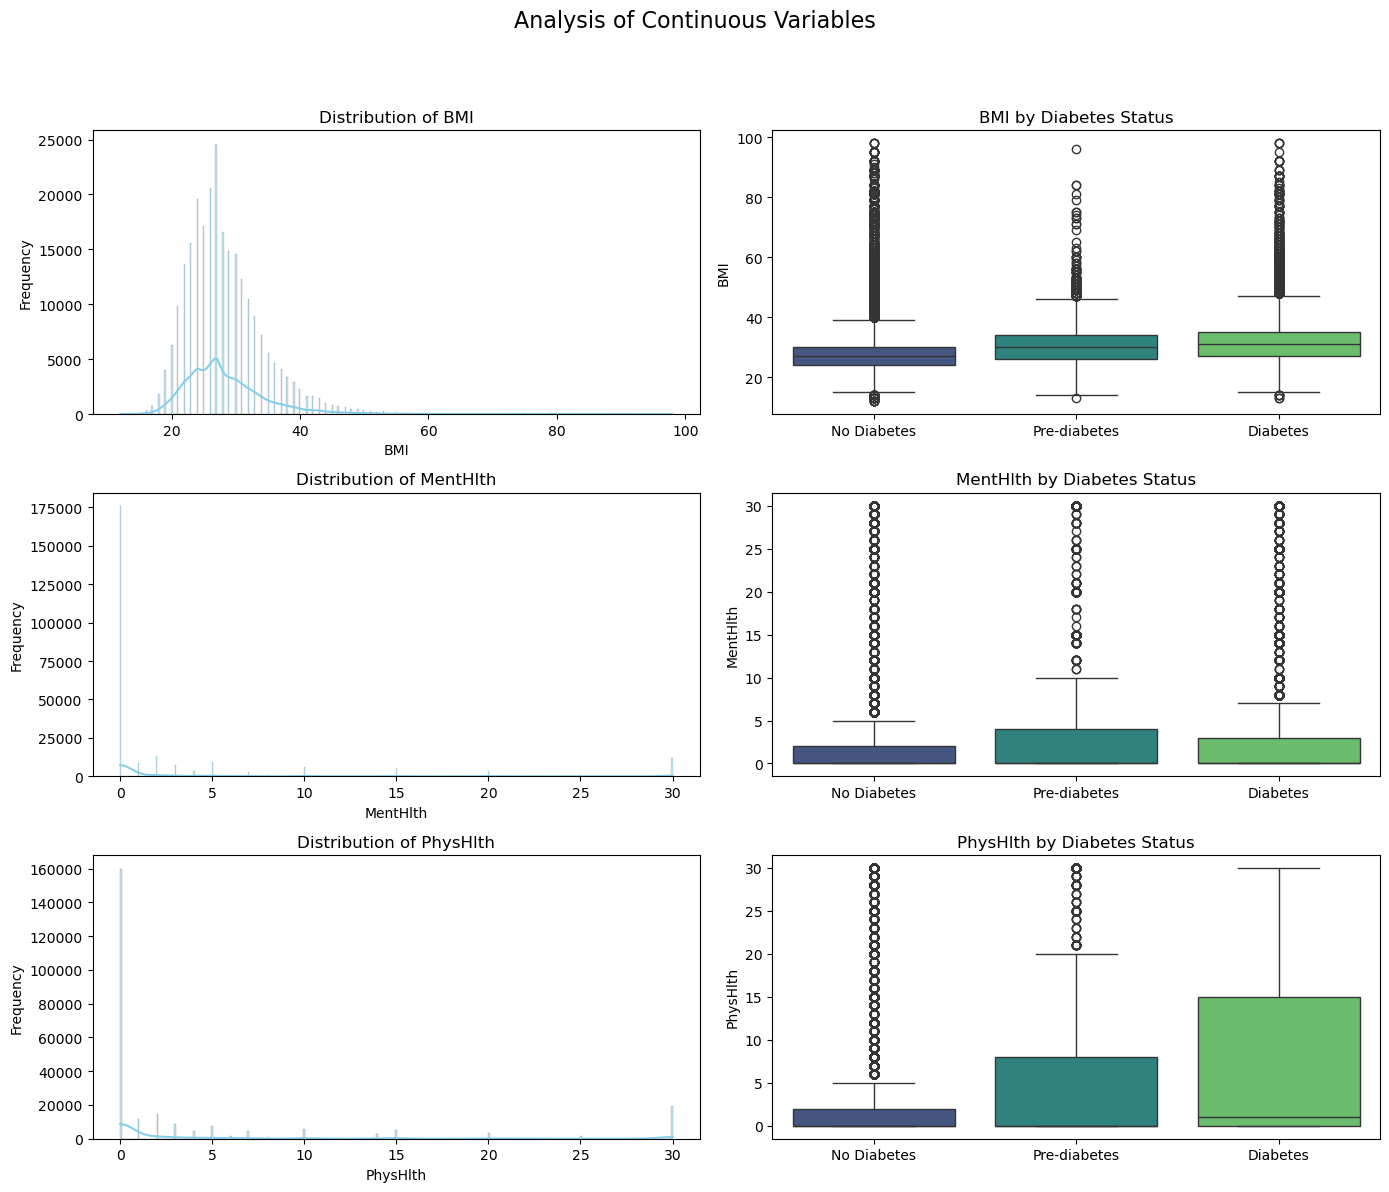

In [16]:
# Continuous Variables Analysis
continuous_features = ["BMI", "MentHlth", "PhysHlth"]

fig, axes = plt.subplots(
    len(continuous_features), 2, figsize=(14, 4 * len(continuous_features))
)
fig.suptitle("Analysis of Continuous Variables", fontsize=16, y=1.02)

for i, var in enumerate(continuous_features):
    sns.histplot(data=df_plot, x=var, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Distribution of {var}")
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Frequency")

    sns.boxplot(
        data=df_plot,
        x="Diabetes_012",
        y=var,
        ax=axes[i, 1],
        palette="viridis",
        hue="Diabetes_012",
        legend=False,
    )
    axes[i, 1].set_title(f"{var} by Diabetes Status")
    axes[i, 1].set_xlabel("")
    axes[i, 1].set_ylabel(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


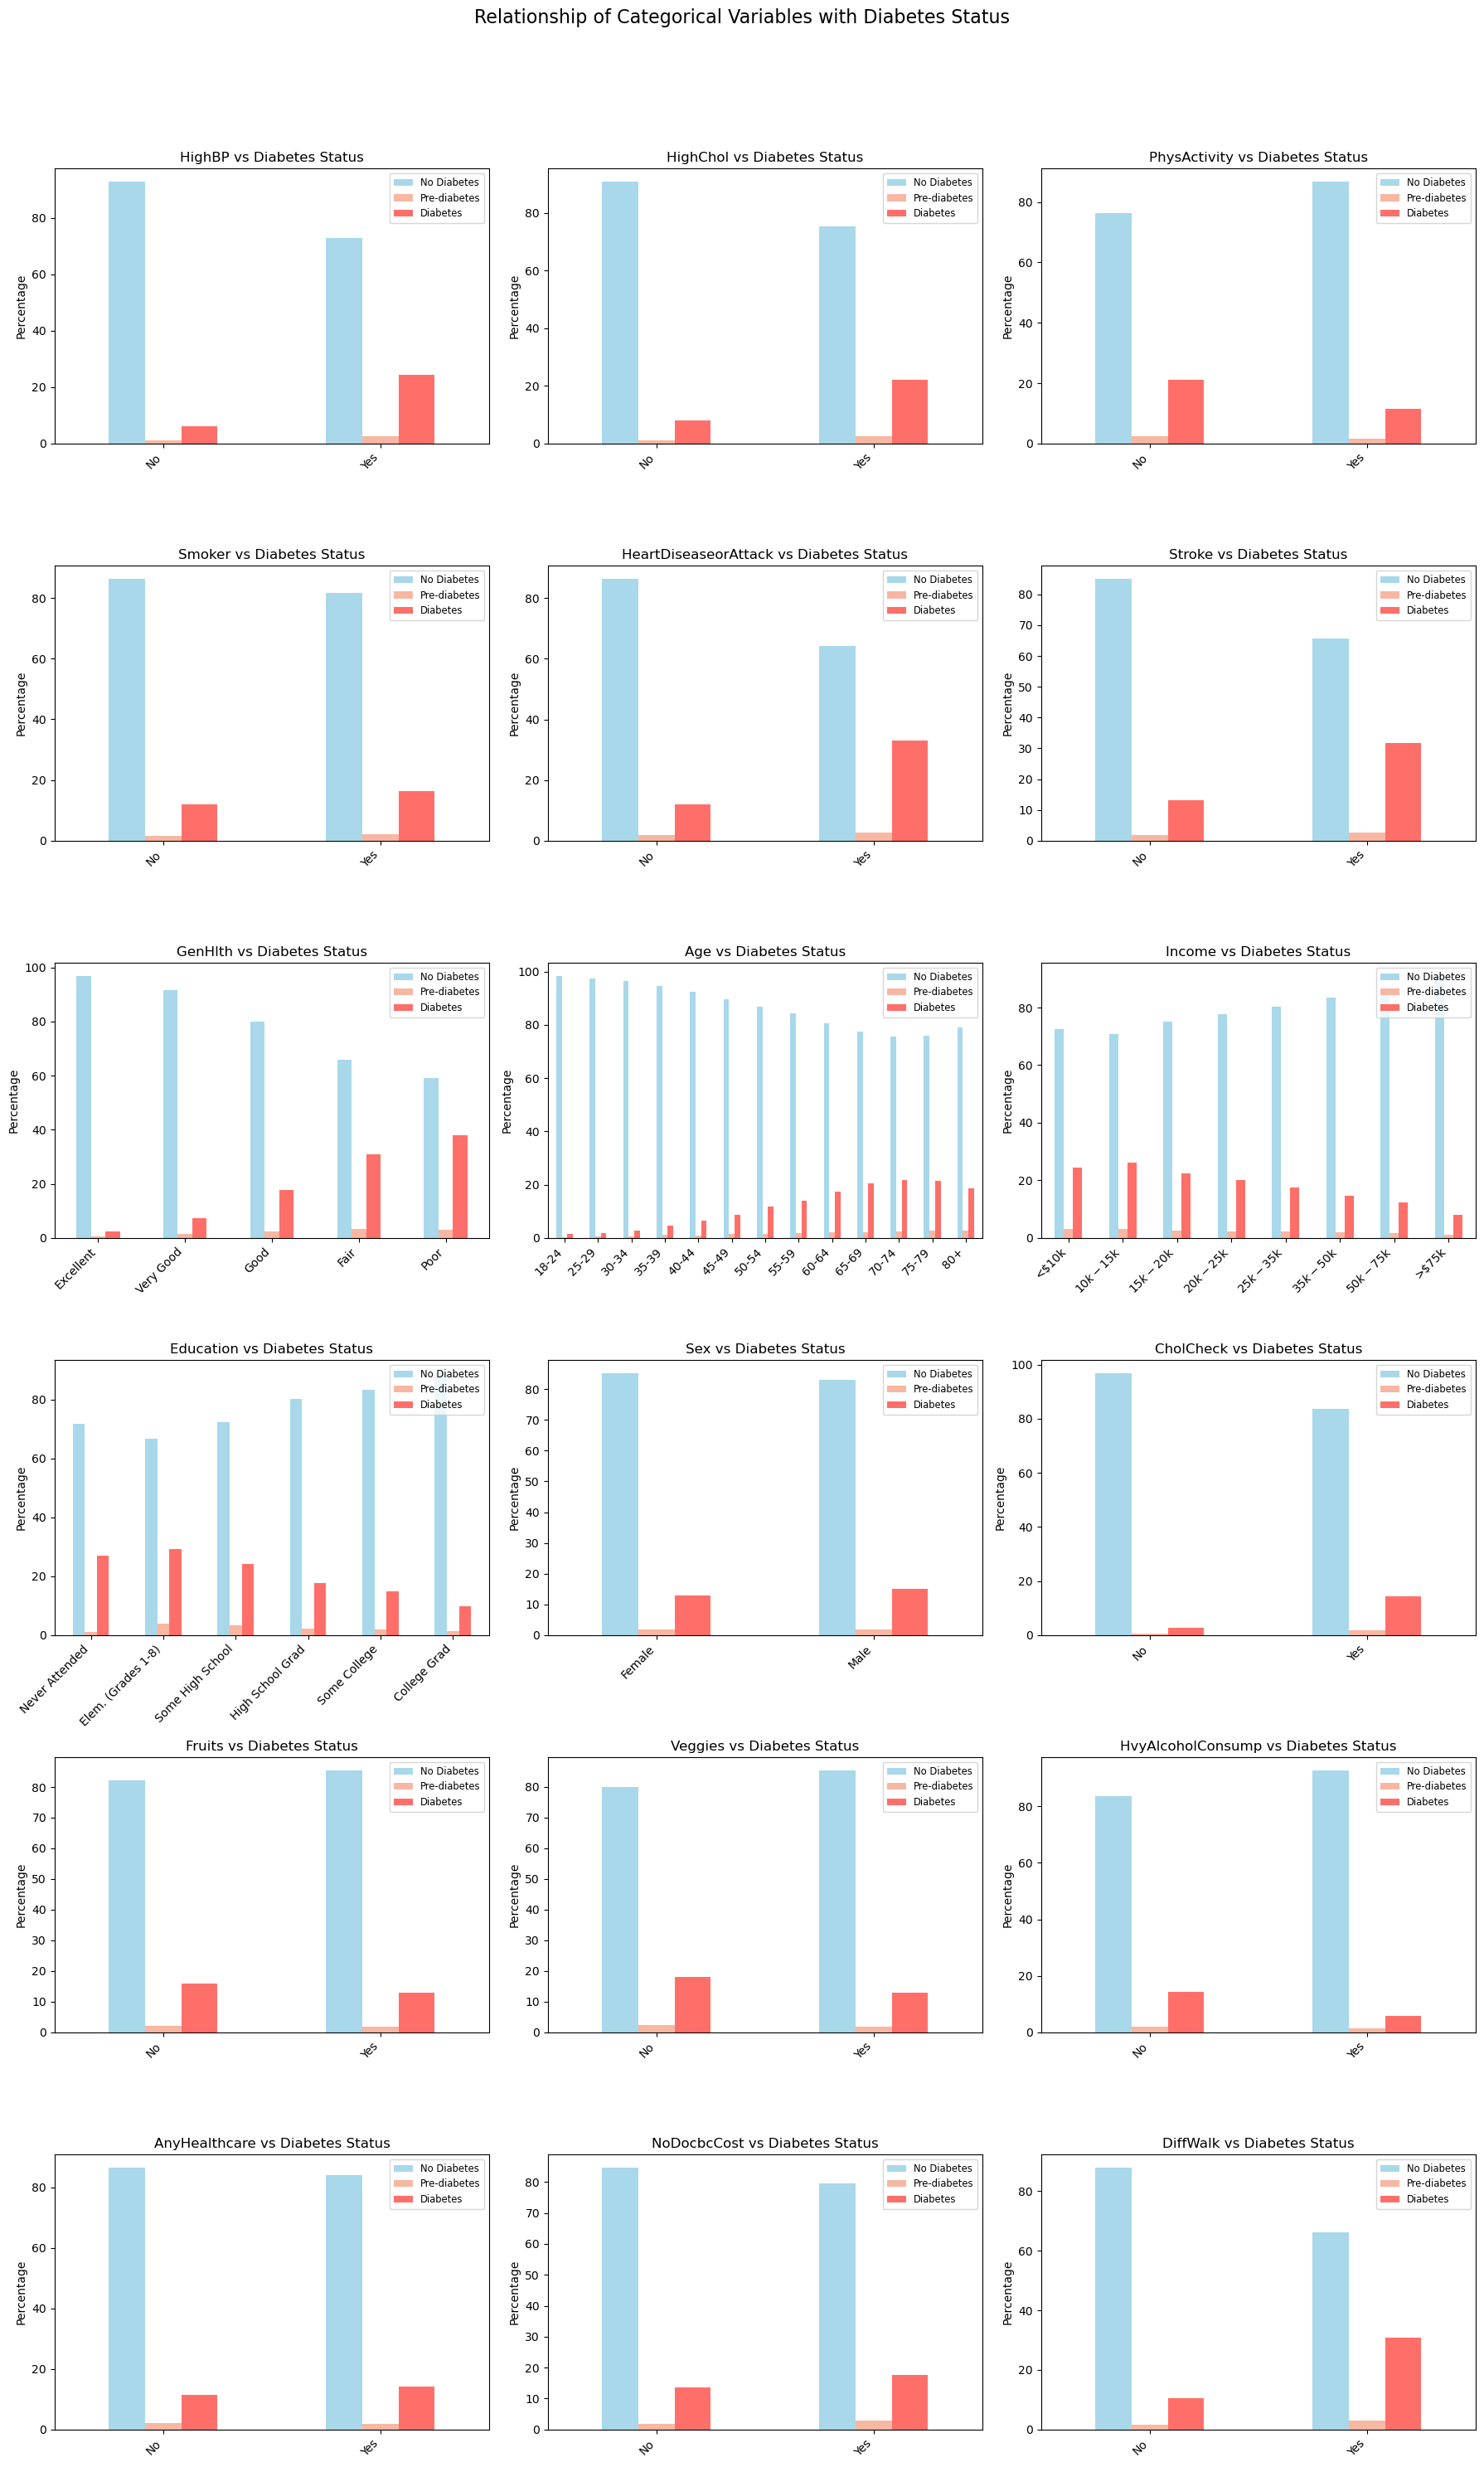

In [17]:
# Categorical Variables Analysis

# List of all categorical features for EDA plots
plot_categorical_features = [
    "HighBP",
    "HighChol",
    "PhysActivity",
    "Smoker",
    "HeartDiseaseorAttack",
    "Stroke",
    "GenHlth",
    "Age",
    "Income",
    "Education",
    "Sex",
    "CholCheck",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
]

# Determine number of rows and columns for subplots dynamically
n_cols = 3
n_rows = (len(plot_categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

fig.suptitle(
    "Relationship of Categorical Variables with Diabetes Status", fontsize=16, y=1.02
)

for i, var in enumerate(plot_categorical_features):
    if i < len(axes):
        ct = pd.crosstab(df_plot[var], df_plot["Diabetes_012"], normalize="index") * 100
        ct.plot(kind="bar", ax=axes[i], color=["#a8d8ea", "#f7b7a3", "#ff6f69"])
        axes[i].set_title(f"{var} vs Diabetes Status")
        axes[i].set_ylabel("Percentage")
        axes[i].set_xlabel(None)
        axes[i].legend(
            ["No Diabetes", "Pre-diabetes", "Diabetes"],
            loc="upper right",
            fontsize="small",
        )
        axes[i].tick_params(axis="x", rotation=45)
        plt.setp(axes[i].get_xticklabels(), ha="right")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


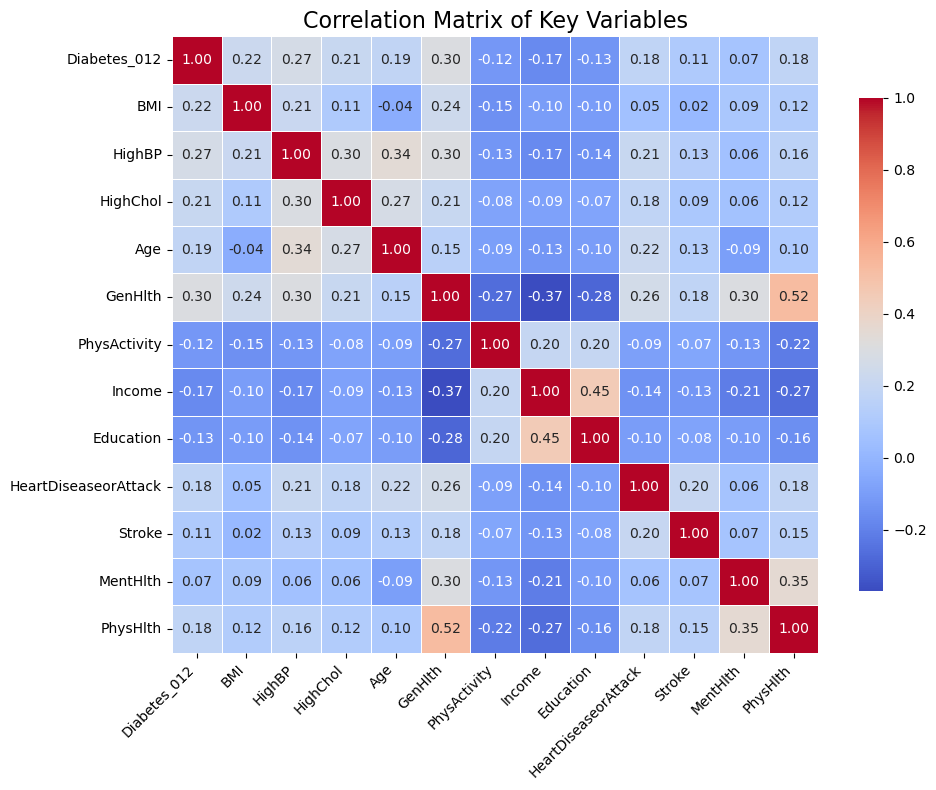

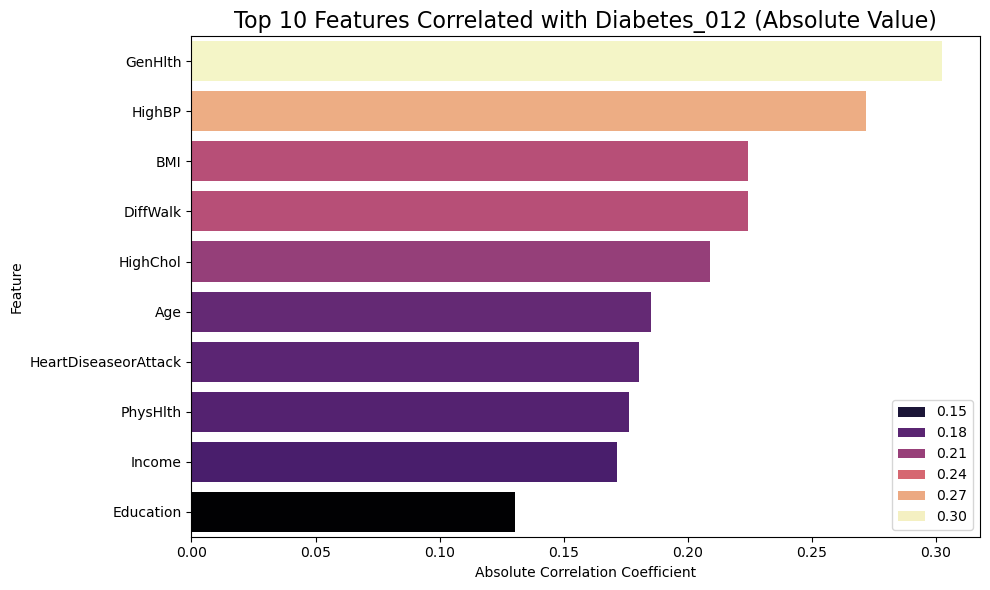


Top 10 features by absolute correlation with Diabetes_012:
GenHlth                 0.302587
HighBP                  0.271596
BMI                     0.224379
DiffWalk                0.224239
HighChol                0.209085
Age                     0.185026
HeartDiseaseorAttack    0.180272
PhysHlth                0.176287
Income                  0.171483
Education               0.130517


In [18]:
# Correlation Heatmap and Top Correlations with Diabetes
plt.figure(figsize=(10, 8))
key_vars_for_corr = [
    "Diabetes_012",
    "BMI",
    "HighBP",
    "HighChol",
    "Age",
    "GenHlth",
    "PhysActivity",
    "Income",
    "Education",
    "HeartDiseaseorAttack",
    "Stroke",
    "MentHlth",
    "PhysHlth",
]
corr_matrix = df[key_vars_for_corr].corr(numeric_only=True)
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix of Key Variables", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
corr_diabetes = (
    df.corr(numeric_only=True)["Diabetes_012"].abs().sort_values(ascending=False)[1:11]
)
sns.barplot(
    x=corr_diabetes.values,
    y=corr_diabetes.index,
    palette="magma",
    hue=corr_diabetes.values,
    dodge=False,
)
plt.title("Top 10 Features Correlated with Diabetes_012 (Absolute Value)", fontsize=16)
plt.xlabel("Absolute Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 features by absolute correlation with Diabetes_012:")
print(corr_diabetes.to_string())

# **5. Data Preprocessing**

In [19]:
# Define feature categories for preprocessing
binary_features = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "HeartDiseaseorAttack",
    "Stroke",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
    "Sex",
]
ordinal_features = ["GenHlth", "Age", "Education", "Income"]
continuous_features = ["BMI", "MentHlth", "PhysHlth"]

# Check if all features are accounted for (excluding target)
all_features_except_target = binary_features + ordinal_features + continuous_features
if set(df.drop("Diabetes_012", axis=1).columns) != set(all_features_except_target):
    print(
        "Warning: Feature categories do not perfectly match DataFrame columns. Please review."
    )

In [20]:
# Split data into training and testing sets
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]

# Stratified split to maintain target distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split: Training {X_train.shape}, Test {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True).round(3)}")

Data split: Training (202944, 21), Test (50736, 21)
Training target distribution:
Diabetes_012
0.0    0.842
2.0    0.139
1.0    0.018
Name: proportion, dtype: float64


In [21]:
# Define the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        (
            "continuous_pipeline",
            Pipeline(
                [
                    (
                        "winsorize",
                        Winsorizer(
                            capping_method="iqr",
                            fold=1.5,
                            variables=continuous_features,
                        ),
                    ),
                    ("scaler", RobustScaler()),
                ]
            ),
            continuous_features,
        ),
        ("ordinal_scaler", RobustScaler(), ordinal_features),
        ("binary_passthrough", "passthrough", binary_features),
    ],
    remainder="drop",
)

# Create the full pipeline including preprocessing, feature selection, and SMOTE
pipeline = ImbalancedPipeline(
    [
        ("preprocess", preprocessor),
        ("feature_selection", DropCorrelatedFeatures(threshold=0.8, method="pearson")),
        ("smote", SMOTE(random_state=42, sampling_strategy="auto")),
    ]
)

# Apply the pipeline to training data (with SMOTE)
print("Applying preprocessing and SMOTE to training data...")
X_train_processed, y_train_processed = pipeline.fit_resample(X_train, y_train)

# Apply only preprocessing and feature selection (without SMOTE)
X_test_processed = pipeline[:-1].transform(X_test)

# Get the final feature names after all transformations and selections
final_feature_names = pipeline.named_steps["feature_selection"].get_feature_names_out()

print(f"Preprocessing complete. Training data shape: {X_train_processed.shape}")
print(f"Test data shape: {X_test_processed.shape}")
print(
    f"Training target distribution after SMOTE:\n{pd.Series(y_train_processed).value_counts(normalize=True).round(3)}"
)
print(f"Number of final features: {len(final_feature_names)}")

Applying preprocessing and SMOTE to training data...
Preprocessing complete. Training data shape: (512886, 21)
Test data shape: (50736, 21)
Training target distribution after SMOTE:
Diabetes_012
0.0    0.333
2.0    0.333
1.0    0.333
Name: proportion, dtype: float64
Number of final features: 21


In [22]:
# Save processed data to CSV files
output_dir = Path("diabetes_health_indicators_preprocessing")
output_dir.mkdir(exist_ok=True)

train_final_df = pd.DataFrame(X_train_processed, columns=final_feature_names)
train_final_df["Diabetes_012"] = y_train_processed

test_final_df = pd.DataFrame(X_test_processed, columns=final_feature_names)
test_final_df["Diabetes_012"] = y_test.reset_index(drop=True)

train_final_df.to_csv(output_dir / "train_processed.csv", index=False)
test_final_df.to_csv(output_dir / "test_processed.csv", index=False)

print(f"Processed data saved to '{output_dir}/'.")
print(
    f"Train data saved: '{output_dir / 'train_processed.csv'}' ({train_final_df.shape})"
)
print(f"Test data saved: '{output_dir / 'test_processed.csv'}' ({test_final_df.shape})")

Processed data saved to 'diabetes_health_indicators_preprocessing/'.
Train data saved: 'diabetes_health_indicators_preprocessing\train_processed.csv' ((512886, 22))
Test data saved: 'diabetes_health_indicators_preprocessing\test_processed.csv' ((50736, 22))
